# Random ER-G

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from IPython.display import display_svg

In [4]:
from pprint import pprint
import numpy as np
import scipy
import pandas as pd
import collections
from itertools import combinations
import networkx as nx
import pywhy_graphs as pgraphs
from pywhy_graphs import AugmentedGraph
from pywhy_graphs.functional import (
    make_graph_linear_gaussian,
    make_graph_multidomain,
    set_node_attributes_with_G,
    apply_linear_soft_intervention,
    sample_multidomain_lin_functions,
)
from pywhy_graphs.viz import draw
from pywhy_graphs.simulate import simulate_random_er_dag

from dodiscover.cd import KernelCDTest
from dodiscover.ci import KernelCITest, FisherZCITest, Oracle
from dodiscover.constraint.skeleton import LearnMultiDomainSkeleton
from dodiscover.constraint.utils import dummy_sample
from dodiscover.datasets import sample_from_graph

from dodiscover import (
    SFCI,
    PsiFCI,
    FCI,
    Context,
    make_context,
    InterventionalContextBuilder,
)
from dodiscover.metrics import (
    structure_hamming_dist,
    confusion_matrix_networks,
    # structure_hamming_dist_ec,
)

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
seed = 12345

In [6]:
alpha = 0.05

In [7]:
def convert_md_data_to_sd(data, domain_indices, intervention_targets):
    # generate single-domain data
    single_domain_data = []
    single_domain_targets = []

    seen_indices = set()
    for targets in intervention_targets:
        indices = [
            idx
            for idx in range(len(domain_indices))
            if intervention_targets[idx] == targets
        ]
        if any(idx in seen_indices for idx in indices):
            continue
        for idx in indices:
            seen_indices.add(idx)

        single_domain_data.append(pd.concat([data[idx] for idx in indices], axis=0))
        if targets == {}:
            continue
        single_domain_targets.append(targets)
    return single_domain_data, single_domain_targets

# Run Experiment

In [8]:
rng = np.random.default_rng(seed)

In [9]:
alpha = 0.2

In [10]:
node_mean_lims = [-1, 1]
node_std_lims = [0.5, 1.5]
edge_functions = [
    lambda x: x,
    lambda x: x**2,
]
edge_weight_lims = [1, 5]
n_node_grid = np.arange(4, 5)
p_grid = np.linspace(0.3, 0.5, 5)
n_domains_grid = np.arange(2, 10)
n_repeats = 1

max_cond_set_size = 3

n_samples = 2000
ratio_interventions = 0.9
n_jobs = -1
print(n_node_grid)
print(p_grid)

[4]
[0.3  0.35 0.4  0.45 0.5 ]


In [20]:
sfci_results = collections.defaultdict(list)
ifci_results = collections.defaultdict(list)
parameters = collections.defaultdict(list)

for n_nodes in n_node_grid:
    n_interventions = int(ratio_interventions * n_nodes)

    for p in p_grid:
        # simulate random ER-graph
        G = simulate_random_er_dag(n_nodes=n_nodes, p=p, seed=seed, ensure_acyclic=True)
        aug_graph = AugmentedGraph(incoming_directed_edges=G)
        # convert graph into a multi-domain linear graph
        aug_lin_graph = make_graph_linear_gaussian(
            aug_graph,
            node_mean_lims=node_mean_lims,
            node_std_lims=node_std_lims,
            edge_functions=edge_functions,
            edge_weight_lims=edge_weight_lims,
            random_state=seed,
        )
        non_augmented_nodes = set(G.nodes)

        for n_domains in n_domains_grid:
            md_lin_graph = sample_multidomain_lin_functions(
                aug_lin_graph,
                n_domains=n_domains,
                node_mean_lims=node_mean_lims,
                node_std_lims=node_std_lims,
                edge_functions=edge_functions,
                edge_weight_lims=edge_weight_lims,
                random_state=seed,
            )
            # keep a copy of the ground-truth graph
            groundtruth_graph = md_lin_graph.copy()

            # now generate interventions
            for idx in range(n_repeats):
                domain_indices = []
                intervention_targets = []
                mechanisms = []
                data = []

                # generate observational distirbution
                for jdx, domain_id in enumerate(range(1, n_domains + 1)):
                    df = sample_from_graph(
                        md_lin_graph,
                        sample_func="multidomain",
                        n_samples=int(n_samples),
                        n_jobs=1,
                        random_state=seed + idx,
                        domain_id=domain_id,
                    )

                    domain_indices.append(domain_id)
                    intervention_targets.append({})
                    mechanisms.append(jdx)
                    data.append(df)
                for jdx in range(n_interventions):
                    # get random node to perturb
                    perturbation = set(
                        rng.choice(
                            list(aug_lin_graph.non_augmented_nodes),
                            size=1,
                            replace=False,
                        )
                    )

                    int_graph = md_lin_graph.copy()

                    # generate a soft-intervention
                    int_graph = apply_linear_soft_intervention(
                        int_graph, targets=perturbation, random_state=seed + idx
                    )

                    # sample data from the intervention distribution
                    df = sample_from_graph(
                        int_graph,
                        sample_func="multidomain",
                        n_samples=n_samples,
                        n_jobs=1,
                        random_state=seed + idx,
                        domain_id=domain_id,
                    )
                    domain_indices.append(domain_id)
                    intervention_targets.append(perturbation)
                    mechanisms.append(jdx)
                    data.append(df)

                # run S-FCI
                context = (
                    make_context(create_using=InterventionalContextBuilder)
                    .variables(aug_graph.non_augmented_nodes)
                    .num_distributions(len(data))
                    .build()
                )
                # now learn the relationships
                learner = SFCI(
                    ci_estimator=FisherZCITest(),
                    cd_estimator=KernelCDTest(null_reps=500),
                    alpha=alpha,
                    debug=False,
                    n_jobs=n_jobs,
                    max_cond_set_size=max_cond_set_size,
                )
                learner.fit(
                    data,
                    context,
                    domain_indices=domain_indices,
                    intervention_targets=intervention_targets,
                )
                spag = learner.graph_

                # run I-FCI
                single_domain_data, single_domain_targets = convert_md_data_to_sd(
                    data, domain_indices, intervention_targets
                )
                context = (
                    make_context(create_using=InterventionalContextBuilder)
                    .variables(aug_graph.non_augmented_nodes)
                    # .obs_distribution(False)
                    .intervention_targets(single_domain_targets)
                    # .mechanisms([{"x": 1}, {"x": 2}])
                    .num_distributions(len(single_domain_data))
                    .build()
                )
                learner = PsiFCI(
                    ci_estimator=FisherZCITest(),
                    cd_estimator=KernelCDTest(null_reps=500),
                    alpha=alpha,
                    known_intervention_targets=True,
                    n_jobs=n_jobs,
                    max_cond_set_size=max_cond_set_size,
                )
                learner.fit(
                    single_domain_data,
                    context,
                )
                ipag = learner.graph_

                # analyze skeleton
                cm_ipag = confusion_matrix_networks(
                    aug_lin_graph.to_undirected(),
                    ipag.subgraph(non_augmented_nodes).to_undirected(),
                )
                cm_spag = confusion_matrix_networks(
                    aug_lin_graph.to_undirected(),
                    spag.subgraph(non_augmented_nodes).to_undirected(),
                )

                # analyze directionality orietnations
                shd_ipag = structure_hamming_dist(
                    aug_lin_graph.sub_directed_graph(),
                    ipag.subgraph(non_augmented_nodes).sub_directed_graph(),
                )
                shd_spag = structure_hamming_dist(
                    aug_lin_graph.sub_directed_graph(),
                    spag.subgraph(non_augmented_nodes).sub_directed_graph(),
                )

                print(cm_ipag, cm_spag)
                print(shd_ipag, shd_spag)

                sfci_results["shd"].append(shd_spag)
                sfci_results["cm_skel"].append(cm_spag)
                ifci_results["shd"].append(shd_ipag)
                ifci_results["cm_skel"].append(cm_ipag)

                # analyze skeleton
                cm_ipag = confusion_matrix_networks(
                    aug_lin_graph.sub_directed_graph(),
                    ipag.subgraph(non_augmented_nodes).sub_directed_graph(),
                )
                cm_spag = confusion_matrix_networks(
                    aug_lin_graph.sub_directed_graph(),
                    spag.subgraph(non_augmented_nodes).sub_directed_graph(),
                )
                print(cm_ipag)
                print(cm_spag)
                sfci_results["cm_direct"].append(cm_spag)
                ifci_results["shd"].append(shd_ipag)
                ifci_results["cm_direct"].append(cm_ipag)
                parameters["idx"].append(idx)
                parameters["n_domains"].append(n_domains)
                parameters["p_edge"].append(p)
                parameters["n_nodes"].append(n_nodes)
                # break
            # break
        break
    break

Exception: The y variables are not all in the DataFrame.

In [144]:
print(n_domains)
print(intervention_targets)
print(len(data))
print(p, n_nodes)

5
[{}, {}, {}, {}, {}, {2}, {3}, {0}]
8
0.3 4


In [167]:
# analyze directionality orietnations
shd_ipag = structure_hamming_dist_ec(
    aug_lin_graph,
    ipag.subgraph(non_augmented_nodes),
)
shd_spag = structure_hamming_dist_ec(
    aug_lin_graph,
    spag.subgraph(non_augmented_nodes),
)

# analyze skeleton
cm_ipag = confusion_matrix_networks(
    aug_lin_graph.sub_directed_graph(),
    ipag.subgraph(non_augmented_nodes).sub_directed_graph(),
)
cm_spag = confusion_matrix_networks(
    aug_lin_graph.sub_directed_graph(),
    spag.subgraph(non_augmented_nodes).sub_directed_graph(),
)

print(cm_ipag)
print(cm_spag)
print(shd_ipag, shd_spag)

[[2 1]
 [0 3]]
[[2 1]
 [1 2]]
2.0 2.0


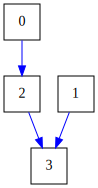

In [161]:
draw(groundtruth_graph)

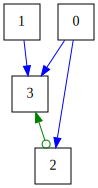

In [162]:
draw(ipag.subgraph(non_augmented_nodes))

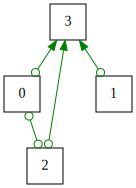

In [163]:
draw(spag.subgraph(non_augmented_nodes))